In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
from sklearn import model_selection
%matplotlib inline

In [5]:
data=pd.read_csv('pg_recommendation_data.csv')

In [9]:
data.head()

,mentee_major,mentee_help_topics,mentee_experitse,mentor_major,mentor_help_topics,mentor_experitse,final_match
0,['Accounting and Financial Management'],"['Life Skills', 'Cover Letter Review', 'Career...",['Accounting'],['Accounting and Financial Management'],"['Parenting vs. Career', 'Career / Industry Tr...","['Finance', 'Accounting']",1
1,['Information Systems Management'],"['Working Overseas', 'Life Skills', 'Startups'...","['Food & Restaurants', 'Law', 'Computer - IT S...","['Information Systems Management', 'Project Ma...","['Leadership Skills', 'Working Overseas', 'Per...","['Trade (Wholesale)', 'Government / Public Adm...",0
2,"['Cybersecurity Technology', 'Computer Network...","['Leadership Skills', 'Personal and Profession...","['Military & Defense', 'Technology', 'Computer...","['Cybersecurity Technology', 'Computer Network...","['Management', 'Resume / CV Review', 'Career /...","['Government / Public Admin', 'Computer - IT S...",1
3,['Masters of Human Resources Management'],[],['Human Resources'],['Business Administration'],"['Leadership Skills', 'Life Skills', 'Intervie...","['Human Resources', 'Advertising / Marketing',...",0
4,['Sociology'],"['Leadership Skills', 'Life Skills', 'Manageme...",['Healthcare'],['Business Administration'],"['Leadership Skills', 'Working Overseas', 'Per...","['Human Resources', 'Computer - Hardware', 'Fi...",0


In [6]:
columns=data.columns
data.shape

(48882, 7)

In [7]:
data.isna().sum()

mentee_major          0
mentee_help_topics    0
mentee_experitse      0
mentor_major          0
mentor_help_topics    0
mentor_experitse      0
final_match           0
dtype: int64

In [8]:
data.isnull().sum()

mentee_major          0
mentee_help_topics    0
mentee_experitse      0
mentor_major          0
mentor_help_topics    0
mentor_experitse      0
final_match           0
dtype: int64

no missing values are present, but data has empty lists

input features are all list type so for analysis we will need to use some kind of encoding to transform the data

In [10]:
data['final_match'].value_counts()

0    24466
1    24416
Name: final_match, dtype: int64

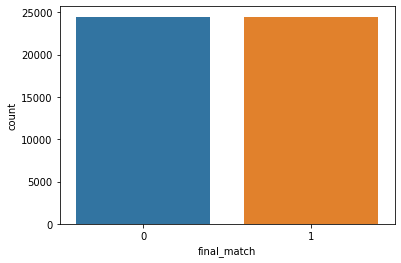

In [11]:
sns.countplot(x='final_match',data=data)

our test set should have the same categories of unique lables, if there is new category, we probably have to drop those rows in train set with category which are not in test sets( undersample). Or we could bring another category for all new categories or the one's which has low ratio of appearing in dataset.

Try 2 tricks 1) with frequency of categories or average 2) use one hot encode of frequent categories+ hashing

I tried the 1st trick in another notebook on this data, named peoplegrove1. if you want to check you can refer that

In this notebook, I am going to convert the data samples with lists to single feature value. The technique will be first to change empty lists to category 'NONE', Then change all categories which has a frequency less than 5 in each column to 'RARE'. After that we select the single value from the list based on highest frequency.

In [6]:
def process(data):
  cols=data.columns
  for i in range(len(data)):
    for col in cols:
      if data.loc[i,col] == '[]':
        data.loc[i,col]='[None]'
  for col in cols:
    if col != 'final_match':
      data[col]=data[col].apply(eval)
  return data


In [7]:
data=process(data)

only two columns have high cardinality mentee_major & mentor_major

In [8]:
def count_dict(data,col):
  cat_dict={}
  for i,row in data.iterrows():
    for word in row[col]:
      if word not in cat_dict:
        cat_dict[word]=1
      else:
        cat_dict[word] +=1
  return cat_dict

In [10]:
dictionary=[]
for col in columns:
  if col != 'final_match':
    cat_dict=count_dict(data,col)
    dictionary.append(cat_dict)
    print('feature {} has {} unique values'.format(col,len(cat_dict)))

feature mentee_major has 3938 unique values
feature mentee_help_topics has 26 unique values
feature mentee_experitse has 57 unique values
feature mentor_major has 2894 unique values
feature mentor_help_topics has 26 unique values
feature mentor_experitse has 57 unique values


In [12]:
def rare_insert(data,col,dic):
  for i,row in data.iterrows():
    for ind,word in enumerate(row[col]):
      if dic[word] < 5:
        data.loc[i,col][ind]='RARE'
  return data

In [13]:
for i in range(len(columns)):
  if columns[i] != 'final_match':
    data=rare_insert(data,columns[i],dictionary[i])

In [16]:
data.to_csv('use_later.csv',index=False)

In [17]:
dictionary_new=[]
for col in columns:
  if col != 'final_match':
    cat_dict=count_dict(data,col)
    dictionary_new.append(cat_dict)
    print('feature {} has {} unique values'.format(col,len(cat_dict)))

feature mentee_major has 1070 unique values
feature mentee_help_topics has 26 unique values
feature mentee_experitse has 57 unique values
feature mentor_major has 1187 unique values
feature mentor_help_topics has 26 unique values
feature mentor_experitse has 57 unique values


Now lets change the list in data to a single value based on frequency except for rare category


In [79]:
def insert_singlevalue(data,col,final_dict):
  for i,row in data.iterrows():
    z={}
    x=row[col]
    for v in x:
      if v not in z:
        z[v]=final_dict[v]
    z=z=sorted(z.items(),key=lambda k:k[1])
    tup=('RARE',final_dict['RARE'])
    if tup not in z:
      data.loc[i,col]=z[-1][0]
    elif len(z) > 1:
      data.loc[i,col]=z[-2][0]
    else:
      data.loc[i,col]='RARE'
  return data

In [91]:
def insert_singlevalue_withoutrare(data,col,final_dict):
  for i,row in data.iterrows():
    z={}
    x=row[col]
    for v in x:
      if v not in z:
        z[v]=final_dict[v]
    z=z=sorted(z.items(),key=lambda k:k[1])
    data.loc[i,col]=z[-1][0]
  return data

In [78]:
data1=data.copy()

In [ ]:
cols=['mentee_major','mentee_help_topics','mentee_experitse','mentor_major','mentor_help_topics','mentor_experitse']

This below cell will take around 8-10 mins to execute on colab cpu

In [ ]:
for i in range(len(cols)):
  if i==0 or i==3:
    data1=insert_singlevalue(data1,cols[i],dictionary_new[i])
  else:
    data1=insert_singlevalue_withoutrare(data1,cols[i],dictionary_new[i])

In [94]:
data1.to_csv('single_feild.csv',index=False)

Below I am going to try different models and encodings on the above transformed data.

**Feature Engineering:** We can find out the importance of features based on variance (say selecting features with variance greater than some threshold.
OR we can also remove features which have high correleation.

I have already done feature engineering in another notebook named peoplegrove1, and found out no feature has variance less than threshold of 0.1, So I have selected all features for modelling.

In [126]:
from sklearn import decomposition
from scipy import sparse
from sklearn import model_selection,preprocessing,metrics
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn import linear_model

In [97]:
import os
import gc
import joblib
import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

**Splittting Data** splitting data using with 80% train size and 20% test size, since the classes in data are evenly balanced we don't need to use class imbalance techniques. Although we can use simple cross validation scheme( here used stratifiedkfold technique).

In [99]:
def cross_valid(df):
  df['kfold']=-1
  df=df.sample(frac=1).reset_index(drop=True)
  y=df.final_match.values
  kf=model_selection.StratifiedKFold(n_splits=5)
  for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,'kfold']=f
  return df

Build Simple Neural Network with entity embedding and see the behaviour, using neural networks is common for data with high cardinality features.

In [118]:
def create_model(data,catcols):
  inputs=[]
  outputs=[]
  for c in catcols:
    num_unique_values=int(data[c].nunique())
    embed_dim=int(min(np.ceil((num_unique_values)/2),50))
    inp=layers.Input(shape=(1,))
    out=layers.Embedding(num_unique_values+1,embed_dim,name=c)(inp)
    out=layers.SpatialDropout1D(0.3)(out)
    out=layers.Reshape(target_shape=(embed_dim,))(out)
    inputs.append(inp)
    outputs.append(out)
  
  x=layers.Concatenate()(outputs)
  x=layers.BatchNormalization()(x)
  x=layers.Dense(300,activation='relu')(x)
  x=layers.Dropout(0.3)(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dense(300,activation='relu')(x)
  x=layers.Dropout(0.3)(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dense(50,activation='relu')(x)
  x=layers.Dropout(0.3)(x)
  x=layers.BatchNormalization()(x)

  y=layers.Dense(1,activation='sigmoid')(x)
  model=Model(inputs=inputs,outputs=y)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model


In [119]:
def runn(df,fold):
  features=[f for f in df.columns if f not in ('final_match','kfold')]
  for col in features:
    df.loc[:, col] = df[col].astype(str)
  for col in features:
    lbl_enc=preprocessing.LabelEncoder()
    df.loc[:,col]=lbl_enc.fit_transform(df[col].values)

  #print
  df_train=df[df.kfold !=fold].reset_index(drop=True)
  df_valid=df[df.kfold==fold].reset_index(drop=True)

  model=create_model(df,features)
  xtrain = [df_train[features].values[:, k] for k in range(len(features))]
  xvalid = [df_valid[features].values[:, k] for k in range(len(features))]
  # fetch target columns
  ytrain = df_train.final_match.values
  yvalid = df_valid.final_match.values

  # ytrain_cat = utils.to_categorical(ytrain)
  # yvalid_cat = utils.to_categorical(yvalid)

  # fit the model
  model.fit(xtrain,ytrain,validation_data=(xvalid, yvalid),verbose=1,batch_size=32,epochs=10)

  loss,acc = model.evaluate(xvalid,yvalid)
  # print roc auc score
  print("acc: %.3f" %acc)
  # print(yvalid[0])
  # print(metrics.roc_auc_score(yvalid, valid_preds))
  # clear session to free up some GPU memory
  K.clear_session()



In [122]:
cv_data=cross_valid(data1)

In [112]:
cv_data.head()

,mentee_major,mentee_help_topics,mentee_experitse,mentor_major,mentor_help_topics,mentor_experitse,final_match,kfold
0,Cyber Security,Career Planning,Computer - IT Services,Cyber Security,Leadership Skills,Computer - IT Services,1,0
1,Computer Networks and Cybersecurity,None,Computer - IT Services,None,Leadership Skills,Human Resources,0,0
2,Criminal Justice and Corrections,Internship Search Strategies,Cybersecurity,Computer Science,None,None,1,0
3,Business Management,Career Planning,Business Services,Business Management,None,Business Services,0,0
4,Business Administration,None,None,Business Administration,None,None,0,0


In [120]:
for i in range(1):
  runn(cv_data,i)

Epoch 1/10
1223/1223 [==============================] - 11s 7ms/step - loss: 0.5862 - accuracy: 0.6859 - val_loss: 0.5069 - val_accuracy: 0.7343
Epoch 2/10
1223/1223 [==============================] - 8s 7ms/step - loss: 0.5251 - accuracy: 0.7265 - val_loss: 0.5015 - val_accuracy: 0.7396
Epoch 3/10
1223/1223 [==============================] - 8s 7ms/step - loss: 0.5123 - accuracy: 0.7366 - val_loss: 0.4929 - val_accuracy: 0.7404
Epoch 4/10
1223/1223 [==============================] - 8s 7ms/step - loss: 0.5071 - accuracy: 0.7398 - val_loss: 0.4894 - val_accuracy: 0.7438
Epoch 5/10
1223/1223 [==============================] - 8s 7ms/step - loss: 0.4993 - accuracy: 0.7445 - val_loss: 0.4884 - val_accuracy: 0.7427
Epoch 6/10
1223/1223 [==============================] - 8s 7ms/step - loss: 0.4948 - accuracy: 0.7449 - val_loss: 0.4904 - val_accuracy: 0.7420
Epoch 7/10
1223/1223 [==============================] - 8s 7ms/step - loss: 0.4892 - accuracy: 0.7493 - val_loss: 0.4888 - val_accuracy

**Encoding :** Here we are kind gonna transform feature categories and test models based on these encodings, I am going to try both label Encoder and OneHot Encoding to observe the results. But the problem with onehot encoding this data is, i will get huge number of columns which will be difficult to execute, so with onehot encoding, i am going to do dimentionality reduction of the data using SVD and keep only 120 high varaince columns.

# use logistic Regression and random forest with OneHot Encoder

In [148]:
def run_onehot(df,fold,md):
  features=[f for f in df.columns if f not in ('final_match','kfold')]
  for col in features:
    df.loc[:, col] = df[col].astype(str)

  df_train=df[df.kfold !=fold].reset_index(drop=True)
  df_valid=df[df.kfold==fold].reset_index(drop=True)

  ohe = preprocessing.OneHotEncoder()
  # fit ohe on training + validation features
  full_data = pd.concat(
  [df_train[features], df_valid[features]],
  axis=0
  )
  ohe.fit(full_data[features])
  x_train = ohe.transform(df_train[features])
  # transform validation data
  x_valid = ohe.transform(df_valid[features])
  # initialize Truncated SVD
  # I am reducing the data to 120 components
  svd = decomposition.TruncatedSVD(n_components=120)
  # fit svd on full sparse training data
  full_sparse = sparse.vstack((x_train, x_valid))
  svd.fit(full_sparse)
  # transform sparse training data
  x_train = svd.transform(x_train)
  # transform sparse validation data
  x_valid = svd.transform(x_valid)
  # initialize the model
  model = md
  # fit model on training data (ohe)
  model.fit(x_train, df_train.final_match.values)
  # predict on validation data
  pred=model.predict(x_valid)
  pred_train=model.predict(x_train)
  acc=metrics.accuracy_score(df_valid.final_match.values,pred)
  train_acc=metrics.accuracy_score(df_train.final_match.values,pred_train)
  # print acc
  print(f"Fold = {fold}, Accuracy = {acc}")
  return model,train_acc,acc

In [139]:
for i in range(5):
  run_onehot(cv_data,i,linear_model.LogisticRegression())

Fold = 0, Accuracy = 0.7126930551293853
Fold = 1, Accuracy = 0.7121816508131329
Fold = 2, Accuracy = 0.7176759410801964
Fold = 3, Accuracy = 0.7108224222585925
Fold = 4, Accuracy = 0.7096972176759411


In [140]:
for i in range(5):
  run_onehot(cv_data,i,ensemble.RandomForestClassifier(n_jobs=-1))

Fold = 0, Accuracy = 0.7304899253349698
Fold = 1, Accuracy = 0.7348880024547407
Fold = 2, Accuracy = 0.7381342062193126
Fold = 3, Accuracy = 0.7231996726677578
Fold = 4, Accuracy = 0.738747954173486


In [145]:
for i in range(5):
  run_onehot(cv_data,i,XGBClassifier())

Fold = 0, Accuracy = 0.7290579932494631
Fold = 1, Accuracy = 0.7284443080699601
Fold = 2, Accuracy = 0.7314852700490998
Fold = 3, Accuracy = 0.7244271685761048
Fold = 4, Accuracy = 0.7290302782324058


# Logistic Regression and Random forest using Label Encoder

In [155]:
def run_labl(df,fold,md):
  features=[f for f in df.columns if f not in ('final_match','kfold')]
  for col in features:
    df.loc[:, col] = df[col].astype(str)
  for col in features:
    lbl = preprocessing.LabelEncoder()
    # fit label encoder on all data
    lbl.fit(df[col])
    # transform all the data
    df.loc[:, col] = lbl.transform(df[col])

  df_train=df[df.kfold !=fold].reset_index(drop=True)
  df_valid=df[df.kfold==fold].reset_index(drop=True)

  # get training data
  x_train = df_train[features].values
  # get validation data
  x_valid = df_valid[features].values
  model = md
  # fit model on training data (ohe)
  model.fit(x_train, df_train.final_match.values)
  # predict on validation data
  pred=model.predict(x_valid)
  pred_train=model.predict(x_train)
  acc=metrics.accuracy_score(df_valid.final_match.values,pred)
  train_acc=metrics.accuracy_score(df_train.final_match.values,pred_train)
  # print acc
  print('Accuracy = ',{acc})
  return model,train_acc,acc

In [142]:
for i in range(5):
  run_labl(cv_data,i,linear_model.LogisticRegression())

Fold = 0, Accuracy = 0.6599161296921346
Fold = 1, Accuracy = 0.5408612048685691
Fold = 2, Accuracy = 0.6558919803600655
Fold = 3, Accuracy = 0.5595335515548282
Fold = 4, Accuracy = 0.5539075286415712


In [143]:
for i in range(5):
  run_labl(cv_data,i,ensemble.RandomForestClassifier())

Fold = 0, Accuracy = 0.7429681906515291
Fold = 1, Accuracy = 0.743581875831032
Fold = 2, Accuracy = 0.7437602291325696
Fold = 3, Accuracy = 0.7222790507364976
Fold = 4, Accuracy = 0.7418166939443536


In [144]:
for i in range(5):
  run_labl(cv_data,i,XGBClassifier())

Fold = 0, Accuracy = 0.7227165797279329
Fold = 1, Accuracy = 0.7217960519586786
Fold = 2, Accuracy = 0.7212561374795418
Fold = 3, Accuracy = 0.7157324058919804
Fold = 4, Accuracy = 0.7190057283142389


In [150]:
run_labl(cv_data,4,XGBClassifier(n_jobs=-1,max_depth=7,n_estimators=200))

Fold = 4, Accuracy = 0.7474427168576104


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=7,
               min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
 0.8043267017848923,
 0.7474427168576104)

From above experiments, It seems obvious that Randomforest and xgboost are perfoming little better than logistic regression. 

**Hyperparameter tuning:** Let fine tune these model's hyperparameter to find the best parameters and accuracy

In [147]:
from matplotlib.legend_handler import HandlerLine2D
def plott(ta,va,param,namex):
  line1, = plt.plot(param, ta, 'b', label='Train ACC')
  line2, = plt.plot(param, va, 'r', label='Test ACC')
  plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
  plt.ylabel('ACCURACY')
  plt.xlabel(namex)
  plt.show()

Tune estimators for RandomForest.

In [158]:
estimators=[50,100,200,300,400,500]
trainn=[]
testt=[]
for est in estimators:
  print('For estimators={}'.format(est))
  _,a,b=run_labl(cv_data,0,ensemble.RandomForestClassifier(n_estimators=est,max_depth=6) )
  trainn.append(a)
  testt.append(b)
  

For estimators=50
Accuracy =  {0.7129998977191367}
For estimators=100
Accuracy =  {0.704408305206096}
For estimators=200
Accuracy =  {0.710749718727626}
For estimators=300
Accuracy =  {0.7067607650608572}
For estimators=400
Accuracy =  {0.7089086631891173}
For estimators=500
Accuracy =  {0.7156592001636494}


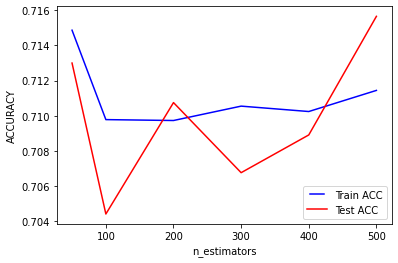

In [159]:
plott(trainn,testt,estimators,'n_estimators')

It seems estimators have irregular effects, lets keep estimator to 200 for now. 
Lets tune max_depth for RandomForest now.

In [160]:
train_accur=[]
valid_accur=[]
max_depth1=[4,6,8,10,12,15,18]
for depth in max_depth1:
  print('For max_depth={}'.format(depth))
  _,a,b=run_labl(cv_data,0,ensemble.RandomForestClassifier(n_estimators=200,max_depth=depth) )
  train_accur.append(a)
  valid_accur.append(b)

For max_depth=4
Accuracy =  {0.6963281170093075}
For max_depth=6
Accuracy =  {0.7110565613173775}
For max_depth=8
Accuracy =  {0.7239439500869387}
For max_depth=10
Accuracy =  {0.7321264191469776}
For max_depth=12
Accuracy =  {0.7418431011557738}
For max_depth=15
Accuracy =  {0.7495141658995602}
For max_depth=18
Accuracy =  {0.7519689066175719}


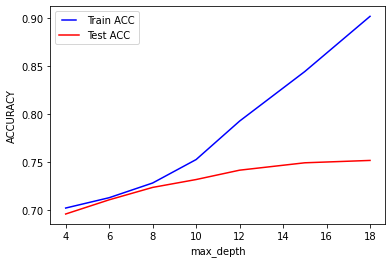

In [161]:
plott(train_accur,valid_accur,max_depth1,'max_depth')

It seems max_depth 12 is fine, after that train set is going to overfit.

In [162]:
finalmodel1,train_acc,valid_acc=run_labl(cv_data,0,ensemble.RandomForestClassifier(n_estimators=200,max_depth=12) )
print('train Accuracy = ',train_acc)
print('valid Accuracy = ',valid_acc)

Accuracy =  {0.7486959189935563}
train Accuracy =  0.7932489451476793
valid Accuracy =  0.7486959189935563


Lets Tune the parameters for **XGBClassifier** now.

In [163]:
train_accuracy=[]
valid_accuracy=[]
max_depth=[4,6,8,10,12,15,18]
for depth in max_depth:
  print('For max_depth={}'.format(depth))
  _,a,b=run_labl(cv_data,0,XGBClassifier(max_depth=depth,learning_rate=0.1,n_estimators=200) )
  train_accuracy.append(a)
  valid_accuracy.append(b)
  print("\n")

For max_depth=4
Accuracy =  {0.7451160887797893}


For max_depth=6
Accuracy =  {0.750536974532065}


For max_depth=8
Accuracy =  {0.7598445330878593}


For max_depth=10
Accuracy =  {0.7567761071903447}


For max_depth=12
Accuracy =  {0.7538099621560806}


For max_depth=15
Accuracy =  {0.7506392553953155}


For max_depth=18
Accuracy =  {0.7538099621560806}




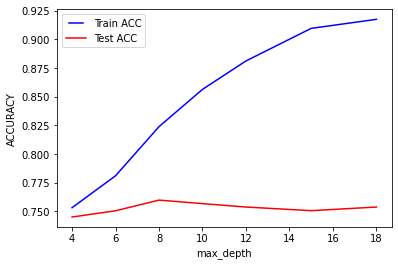

In [164]:
plott(train_accuracy,valid_accuracy,max_depth,'max_depth')

max_depth of 8 for xgb seeems okay, lets tume learning rate now.

In [165]:
learning_rate=[0.05,0.01,0.1,0.15]
tr=[]
tes=[]
for lr in learning_rate:
  print('For learning_rate ={}'.format(lr))
  _,a,b=run_labl(cv_data,0,XGBClassifier(max_depth=8,learning_rate=lr,n_estimators=200) )
  tr.append(a)
  tes.append(b)
  print("\n")

For learning_rate =0.05
Accuracy =  {0.7527871535235757}


For learning_rate =0.01
Accuracy =  {0.7301830827452184}


For learning_rate =0.1
Accuracy =  {0.7567761071903447}


For learning_rate =0.15
Accuracy =  {0.7599468139511097}




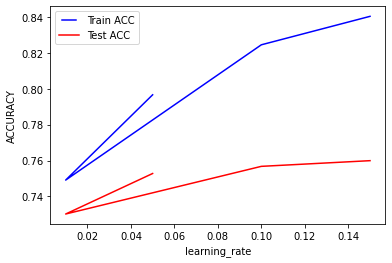

In [166]:
plott(tr,tes,learning_rate,'learning_rate')

learning rate of 0.1 seems best among the choices. lets check estimators now.

In [167]:
estimators=[50,100,200,300,400,500]
trainn=[]
testt=[]
for est in estimators:
  print('For estimators={}'.format(est))
  _,a,b=run_labl(cv_data,0,XGBClassifier(max_depth=8,learning_rate=0.1,n_estimators=est) )
  trainn.append(a)
  testt.append(b)
  

For estimators=50
Accuracy =  {0.7479799529508029}
For estimators=100
Accuracy =  {0.7534008387030786}
For estimators=200
Accuracy =  {0.7553441751048379}
For estimators=300
Accuracy =  {0.7579011966861}
For estimators=400
Accuracy =  {0.7626061163956224}
For estimators=500
Accuracy =  {0.7632198015751253}


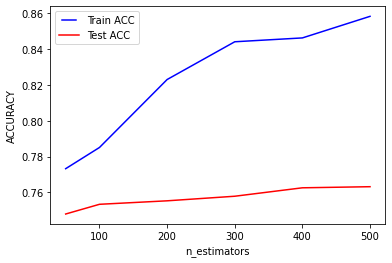

In [168]:
plott(trainn,testt,estimators,'n_estimators')

I think 400 estimators seems fine for xgb, although it does not really matter because i can use early_stopping_rounds for this to stop when validation accuracy doesnot improve

In [169]:
finalmodel2,train_acc,valid_acc=run_labl(cv_data,0,XGBClassifier(max_depth=8,learning_rate=0.1,n_estimators=400)  )
print('train Accuracy = ',train_acc)
print('valid Accuracy = ',valid_acc)

Accuracy =  {0.7583103201391019}
train Accuracy =  0.8524741081703107
valid Accuracy =  0.7583103201391019


In [170]:
print(finalmodel2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [172]:
for i in range(5):
  finalmodel2,train_acc,valid_acc=run_labl(cv_data,i,XGBClassifier(max_depth=8,learning_rate=0.1,n_estimators=400)  )

Fold 0
Accuracy =  {0.7593331287716069}
Fold 1
Accuracy =  {0.7631175207118748}
Fold 2
Accuracy =  {0.7586947626841244}
Fold 3
Accuracy =  {0.7504091653027823}
Fold 4
Accuracy =  {0.7585924713584288}


So, We have final accuracy of around 76%

In [173]:
finalmodel3,train_acc,valid_acc=run_onehot(cv_data,4,XGBClassifier(max_depth=8,learning_rate=0.1,n_estimators=400)  )

Fold = 4, Accuracy = 0.7406914893617021


In [262]:
labels=[]
def fulldata_model(df):
  features=[f for f in df.columns if f not in ('final_match','kfold')]
  for col in features:
    df.loc[:, col] = df[col].astype(str)
  for col in features:
    lbl = preprocessing.LabelEncoder()
    # fit label encoder on all data
    lbl.fit(df[col])
    # transform all the data
    df.loc[:, col] = lbl.transform(df[col])
    labels.append(lbl)

  X=df[features].values
  y=df.final_match.values
  model = XGBClassifier(max_depth=8,learning_rate=0.1,n_estimators=400) 
  model.fit(X,y)
  pred=model.predict(X)
  train_acc=metrics.accuracy_score(y,pred)
  # print acc
  print('accuracy = ',train_acc)
  return model,labels

In [263]:
dff=data1.copy()
dff=dff.sample(frac=1).reset_index(drop=True)


In [264]:
model,labels=fulldata_model(dff)

accuracy =  0.841598134282558


# Test new data of same format

First step is to store location of the csv file in below url, and then execute the cells below to get predictions on this data. 

Remember we would require model, labels and dictionary_new from the train sets to produce results in Test set.

In [279]:
def rare_insert2(data,col,dic):
  for i,row in data.iterrows():
    for ind,word in enumerate(row[col]):
      if word not in dic:
        data.loc[i,col][ind]='RARE'
  return data

In [283]:
#insert the url of the test file
url=''

In [284]:
def test_model(url):
  test_data=pd.read_csv(url)
  test_data=process(test_data)
  test_data=test_data.loc[0:200,:]
  features=[f for f in test_data.columns if f != 'final_match']
  for i in range(len(features)):
    test_data=rare_insert2(test_data,features[i],dictionary_new[i])
    if i==0 or i==3:
      test_data=insert_singlevalue(test_data,features[i],dictionary_new[i])
    else:
      test_data=insert_singlevalue_withoutrare(test_data,features[i],dictionary_new[i])
  
  for i in range(len(features)):
    test_data.loc[:, features[i]]=test_data[features[i]].astype(str)
    test_data.loc[:, features[i]] = labels[i].transform(test_data[features[i]])

  test_X=test_data[features].values
  test_y=test_data.final_match.values

  predictions=model.predict(test_X)
  return predictions

In [285]:
predictions=test_model(url)